# Compiling Rasterized Image Arrays and Figures

#### July 13, 2022

- Creates functions for rasterizing ST datasets including gene expression information, performing PCA, creating scree plots, and saving all the results
- Does the above for MERFISH datasets

In [1]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import glob
import torch
import pprint

from scipy.stats import rankdata
import nrrd
import time

import tools

import imp
imp.reload(tools)

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses


<module 'tools' from '/ifshome/oamiuwu/rasterization_work/tools.py'>

In [2]:
def rasterizePCA(x, y, G):
    
    imp.reload(tools)
    nrows=0
    ncols=0
    
    for i in range(G.shape[1]):
        g = np.array(G.iloc[:,i])
        
        XI,YI,I = tools.rasterize(x,y,g,dx=30.0,blur=1.0,expand=1.1, draw=0, 
                              wavelet_magnitude=True, use_windowing=True)
        
        if(i==0):
            # dimensions
            nrows=YI.size
            ncols=XI.size
            X = np.empty([G.shape[1], nrows, ncols])
            Y = np.empty([G.shape[1], nrows*ncols])
        
        # centers data
        X[i] = np.array(I)
        I_ = I.ravel()
        meanI = np.mean(I_)
        I_ -= meanI
        Y[i] = I_
        
        if(i % 50 == 0):
            print(f"{i} out of {G.shape[1]} genes rasterized.")
        
    S = np.cov(Y) # computes covariance matrix
    W,V = np.linalg.eigh(S) # W = eigenvalues, V = eigenvectors
    
    # reverses order to make it descending by eigenvalue
    W = W[::-1]
    V = V[:,::-1]
    Z = V.T @ Y
    
    return X, Y, W, V, Z, nrows, ncols

In [3]:
# exception if W.size > p
def make_scree(W, name, p=6):
    
    fig, ax = plt.subplots()
    
    ax.bar(range(p),W[:p],width=.9,tick_label=range(1,p+1))
    ax.plot(W[:p],'ko-',linewidth=1)

    ax.set_title("Scree Plot: First %s PCs (%s)" %(p,name), fontsize=18,fontweight='bold')
    ax.set_xlabel('Principal Components')
    ax.set_ylabel("Eigenvalues")
    
    return fig

In [4]:
#fig.savefig
#save variable and save jpeg
def saveRasters(X, Y, W, V, Z, scree_fig, nrows, ncols, name):
    
    I_pca = Z.reshape((Z.shape[0], nrows, ncols))
    I_rgb = np.array(I_pca[:6].transpose(1,2,0))
    I_rgb[...,:] = tools.normalize(I_rgb[...,:])
    
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(I_rgb[:,:,:3])
    axs[1].imshow(I_rgb[:,:,3:])
    
    fig.suptitle("Principal Components in RGB (%s)" %name, fontsize=18,fontweight='bold')
    axs[0].set_title("PCs 1-3")
    axs[1].set_title("PCs 4-6")
    
    scree_fig.savefig(f"/nafs/dtward/stalign/{name}_screefig.jpg")
    fig.savefig(f"/nafs/dtward/stalign/{name}_rgbfig.jpg")
    np.savez(f"/nafs/dtward/stalign/{name}_arrays", X=X, Y=Y, W=W, V=V, Z=Z, I_pca=I_pca, I_rgb=I_rgb,
             screefig=scree_fig, rgbfig = fig)
    
    print(f"Saved all {name} files!\n")
    
#ran into problem by hardcoding in dimensions of pixel array. 
#for file i=-4 it is 256x336. not the same for the others though

In [5]:
# grabs metadata files
meta_files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*metadata*.csv.gz')
meta_files.sort()

# grabs "by_gene" files
gene_files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*by_gene*.csv.gz')
gene_files.sort()

names = ['S1R1','S1R2','S1R3','S2R1','S2R2','S2R3','S3R1','S3R2','S3R3']

In [6]:
# checks that IDs for metadata df and gene df are in the same order
for file in range(9):
    df_meta = pd.read_csv(meta_files[file])
    df_gene = pd.read_csv(gene_files[file])

    if not df_gene["Unnamed: 0"].equals(df_meta["Unnamed: 0"]):
        print("IDs need to be sorted.")

Performing PCA on S1R1:
0 out of 484 genes rasterized.
50 out of 484 genes rasterized.
100 out of 484 genes rasterized.
150 out of 484 genes rasterized.
200 out of 484 genes rasterized.
250 out of 484 genes rasterized.
300 out of 484 genes rasterized.
350 out of 484 genes rasterized.
400 out of 484 genes rasterized.
450 out of 484 genes rasterized.
Saved all S1R1 files!

Performing PCA on S1R2:
0 out of 484 genes rasterized.
50 out of 484 genes rasterized.
100 out of 484 genes rasterized.
150 out of 484 genes rasterized.
200 out of 484 genes rasterized.
250 out of 484 genes rasterized.
300 out of 484 genes rasterized.
350 out of 484 genes rasterized.
400 out of 484 genes rasterized.
450 out of 484 genes rasterized.
Saved all S1R2 files!

Performing PCA on S1R3:
0 out of 484 genes rasterized.
50 out of 484 genes rasterized.
100 out of 484 genes rasterized.
150 out of 484 genes rasterized.
200 out of 484 genes rasterized.
250 out of 484 genes rasterized.
300 out of 484 genes rasterized.


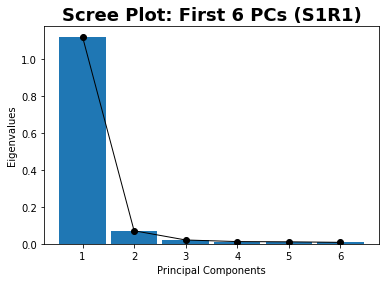

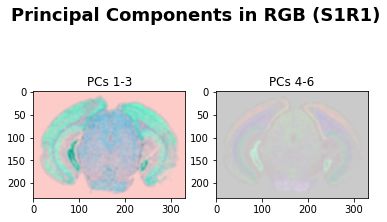

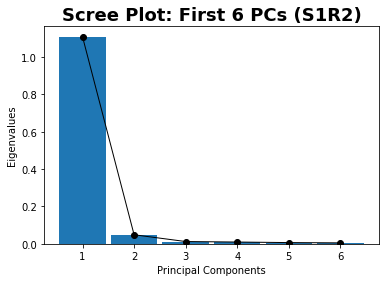

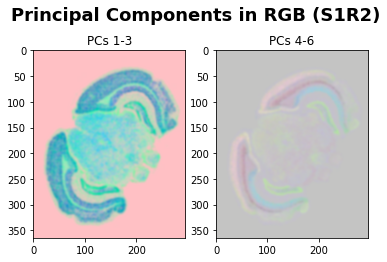

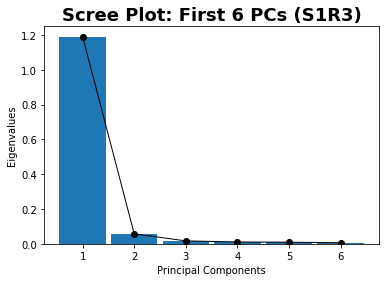

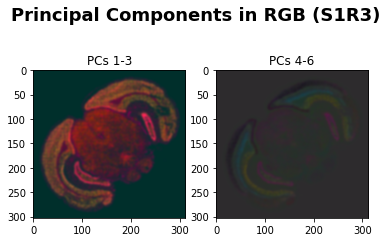

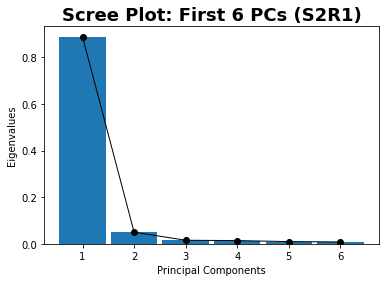

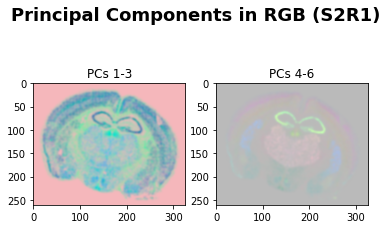

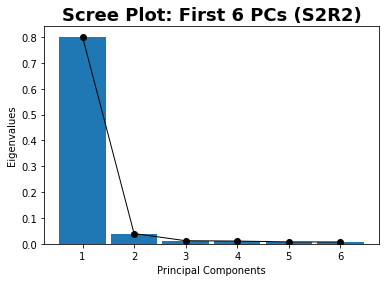

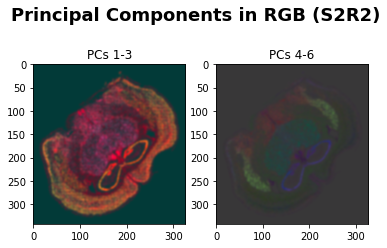

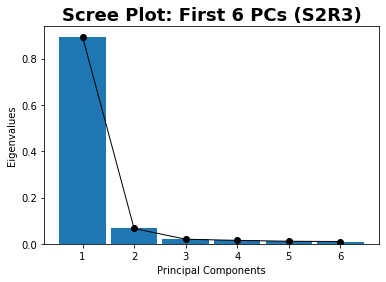

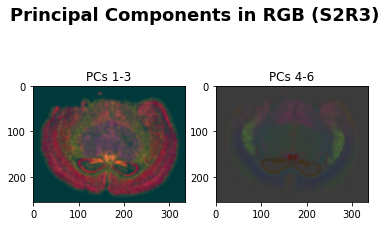

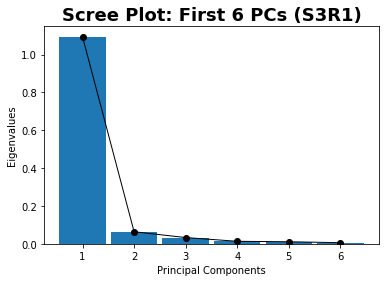

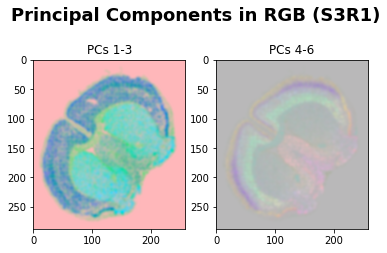

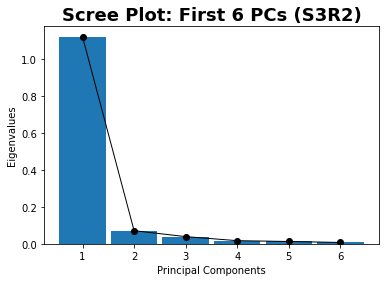

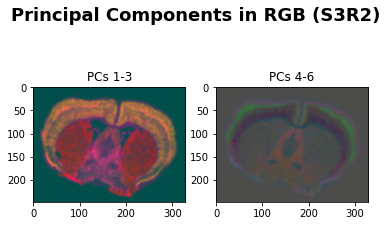

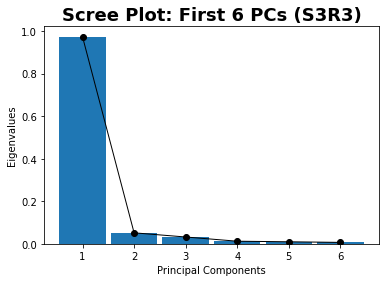

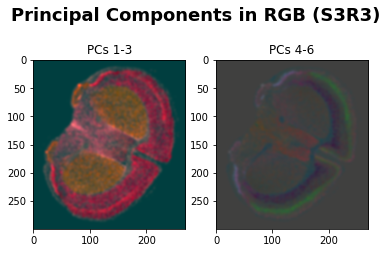

In [6]:
for file in range(9):
    name = names[file]
    df_meta = pd.read_csv(meta_files[file])
    df_gene = pd.read_csv(gene_files[file])
    
    xI = np.array(df_meta['center_x']) # x coordinates
    yI = np.array(df_meta['center_y']) # y coordinates
    geneExpr = df_gene.iloc[:,1:484] # gene expression data, without ID or blanks
    geneExpr["cell"] = 1.0
    
    print(f"Performing PCA on {name}:")
    
    X,Y,W,V,Z,nrows,ncols = rasterizePCA(xI, yI, geneExpr)
    scree_fig = make_scree(W, name)
    saveRasters(X, Y, W, V, Z, scree_fig, nrows, ncols, name)